In [396]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ripser
import persim

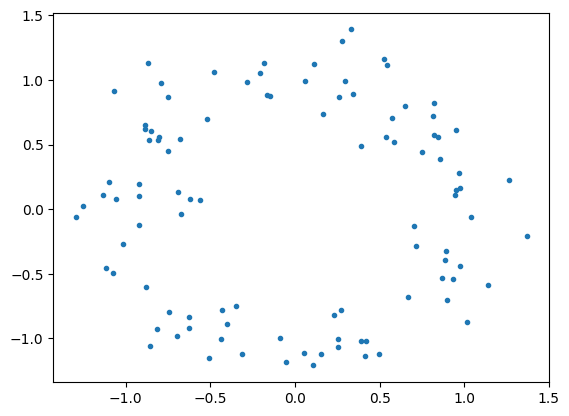

In [9]:
# reading the circle
X = np.loadtxt("../R/unitCircle.csv", skiprows=1, delimiter=",")
plt.plot(X[:,0], X[:,1], ".")

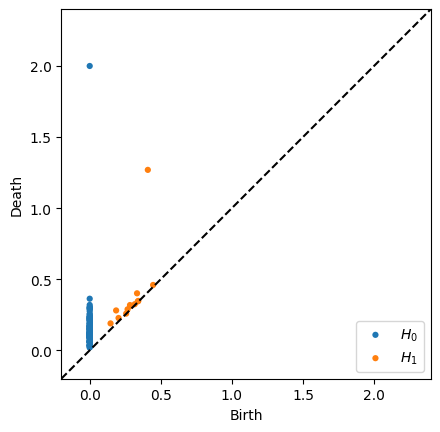

In [116]:
D = ripser.ripser(X, thresh=2)["dgms"]
D[0][-1, 1] = 2
persim.plot_diagrams(D)

In [117]:
def DiagToPD(D):
    PD = [pd.DataFrame({
        "dim":dim, "b":D[dim][:,0], "p":(D[dim][:,1]-D[dim][:,0])
        }) for dim in range(len(D))]
    PD = pd.concat(PD)
    return PD


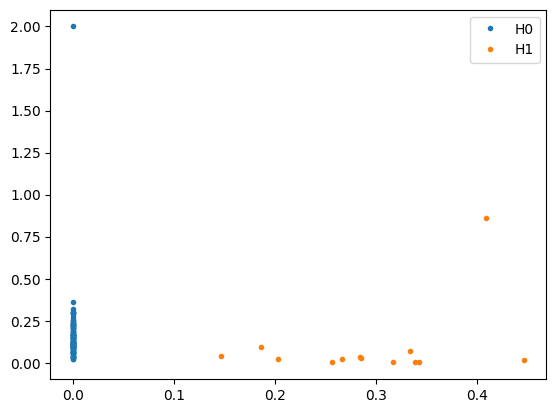

In [118]:
PD = DiagToPD(D)
for dim in PD["dim"].drop_duplicates():
    pd_ = PD[PD["dim"]==dim]
    plt.plot(pd_["b"], pd_["p"], ".", label = "H"+str(dim))
plt.legend()

In [119]:
# Compare with R results
pd_R = pd.read_csv("../R/PD.csv")
for dim in PD["dim"].drop_duplicates():
    print("dim=", dim)
    for var in ["Birth", "Persistence"]:
        perPy = PD[PD["dim"]==dim][var[0].lower()].sort_values().to_numpy()
        perR =  pd_R[pd_R["dimension"]==dim][var].sort_values().to_numpy()
        diff = perPy - perR
        diff = diff[:-1]
        print("\t", var, ": ", max(abs(diff)))


dim= 0
	 Birth :  0.0
	 Persistence :  1.2275210570233952e-08
dim= 1
	 Birth :  1.4883316690195159e-08
	 Persistence :  2.435955601121087e-08


In [327]:
ySeqH0 = [0.02041084, 0.08344844, 0.11463878, 0.15101483, 0.21628494, 2.00000000]
diff = np.quantile(PD[PD["dim"]==0]["p"], np.arange(0, 1.1, 0.2)) - ySeqH0
print("y H0: ", sum(abs(diff)))
#
xSeqH1 = [0.1465692, 0.2243164, 0.2800285, 0.3200161, 0.3404307, 0.4460450]
diff = np.quantile(PD[PD["dim"]==1]["b"], np.arange(0, 1.1, 0.2)) - xSeqH1
print("x H1: ", sum(abs(diff)))
#
ySeqH1 = [0.001683940, 0.006422564, 0.020160192, 0.028070682, 0.057836529, 0.860326686]
diff = np.quantile(PD[PD["dim"]==1]["p"], np.arange(0, 1.1, 0.2)) - ySeqH1
print("y H1: ", sum(abs(diff)))


y H0:  1.4247217156038161e-08
x H1:  1.6027660373896246e-07
y H1:  8.299978638149491e-08


In [373]:
homDim = 0
ySeq = ySeqH0
tau = 0.3
x = PD[PD["dim"]==homDim]["b"].to_numpy()
y = PD[PD["dim"]==homDim]["p"].to_numpy()
dy = np.diff(ySeq)
lam = tau * y
vpb = np.zeros( len(dy))
for i in range(len(dy)):
    c = ySeq[i]
    d = ySeq[i+1]
    for j in range( len(y)):
        if c - lam[j] < y[j] and y[j] < d + lam[j]:
            y_cd = y[j]
            lam_cd = lam[j]
            yMin = max(c, y_cd - lam_cd)
            yMax = min(d, y_cd + lam_cd)
            vpb[i] += 0.5*(yMax**2 - yMin**2)/dy[i]


In [435]:
def computeVPB_dim0(x, y, ySeq, lam):
    dy = np.diff(ySeq)
    vpb = np.zeros( len(dy))
    for i in range(len(dy)):
        c = ySeq[i]
        d = ySeq[i+1]
        for j in range( len(y)):
            if c - lam[j] < y[j] and y[j] < d + lam[j]:
                y_cd = y[j]
                lam_cd = lam[j]
                yMin = max(c, y_cd - lam_cd)
                yMax = min(d, y_cd + lam_cd)
                vpb[i] += 0.5*(yMax**2 - yMin**2)/dy[i]
    return vpb

def pmax(num, vec):
    return np.array([max(num, vec[i_]) for i_ in range(vec.size)])
def pmin(num, vec):
    return np.array([min(num, vec[i_]) for i_ in range(vec.size)])

def computeVPB_dim1(x, y, xSeq, ySeq, lam):
    dx = np.diff(xSeq)
    dy = np.diff(ySeq)
    vpb = np.zeros( (dx.size, dy.size))
    for i in range(dy.size):
        c = ySeq[i]
        d = ySeq[i+1]
        yInd = np.where( (c - lam < y) & (y < d+lam) )[0]
        if yInd.size>0:
            y_cd = y.take(yInd).to_numpy()
            x_cd = x.take(yInd).to_numpy()
            lam_cd = lam.take(yInd).to_numpy()
            yMin_cd =pmax(c, y_cd-lam_cd)
            yMax_cd = pmin(d, y_cd+lam_cd)
            for j in range( dx.size):
                a = xSeq[j]
                b = xSeq[j+1]
                xInd = np.where( (a - lam_cd < x_cd) & (x_cd < b+lam_cd) )[0]
                if xInd.size>0:
                    x_abcd = x_cd.take(xInd)
                    lam_abcd = lam_cd.take(xInd)
                    xMin = pmax(a, x_abcd - lam_abcd)
                    xMax = pmin(b, x_abcd + lam_abcd)
                    yMin = yMin_cd.take(xInd)
                    yMax = yMax_cd.take(xInd)
                    vpb[i, j] += 0.5*np.sum( (xMax-xMin)*(yMax-yMin)*(xMin+xMax+yMin+yMax))/dx[i]/dy[j]
    return vpb

def computeVPB(PD, homDim, xSeq, ySeq, tau=0.3):
    x = PD[PD["dim"]==homDim]["b"] 
    y = PD[PD["dim"]==homDim]["p"]
    dy = np.diff(ySeq)
    lam = tau * y
    if homDim == 0:
        return computeVPB_dim0(x, y, ySeq, lam)
    else:
        return computeVPB_dim1(x, y, xSeq, ySeq, lam)


vpb0 = computeVPB(PD, homDim=0, xSeq=[], ySeq=ySeqH0)
vpb1 = computeVPB(PD, homDim = 1, xSeq=xSeqH1, ySeq=ySeqH1)

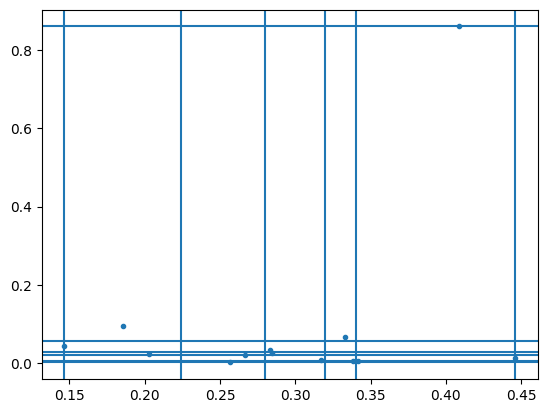

In [290]:
x = PD[PD["dim"] == 1]["b"]
y = PD[PD["dim"] == 1]["p"]
plt.plot(x, y, ".")
for x_ in xSeqH1:
    plt.axvline(x_)
for y_ in ySeqH1:
    plt.axhline(y_)


In [274]:
np.round(vpb1, 2)

array([[ 0.  ,  1.93,  4.42,  2.84,  0.05],
       [ 2.35,  3.01,  8.65,  3.96,  0.17],
       [ 3.27,  5.25,  5.32,  0.  ,  0.  ],
       [ 6.7 , 10.29, 10.43,  0.  ,  0.  ],
       [44.2 , 15.15, 26.31,  6.99,  0.26]])

In [483]:
homDim = 1

# xSeq = np.arange(0, 0.8, 0.2)
xSeq = xSeqH1
dx = np.diff(xSeq)
# ySeq = np.arange(0, 1, 0.2)
ySeq = ySeqH1

dy = np.diff(ySeq)
x = PD[PD["dim"]==homDim]["b"].to_numpy()
y = PD[PD["dim"]==homDim]["p"].to_numpy()
lam = tau * y

vpb = np.zeros( (dx.size, dy.size) )
for i in range(dx.size):
    a, b = xSeq[i], xSeq[i+1]
    for j in range(dy.size):
        c, d = ySeq[j], ySeq[j+1]
        xCond = (x+lam >= a) & (x-lam <= b)
        yCond = (y+lam >= c) & (y-lam <= d)
        inds = np.where(xCond & yCond)[0]
        if len(inds)>0:
            xInd, yInd, lamInd = x.take(inds), y.take(inds), lam.take(inds)
            xMin, xMax = pmax(a, xInd - lamInd), pmin(b, xInd + lamInd)
            yMin, yMax = pmax(c, yInd - lamInd), pmin(d, yInd + lamInd)
            add = 0.5*np.sum( (xMax-xMin)*(yMax-yMin)*(xMax+xMin+yMax+yMin))/dx[i]/dy[j]
            vpb[i, j] += add
        

In [484]:
vpb_ = np.transpose(vpb).reshape( (25,))
max(abs(
    vpb_ - 
    [ 0.0000000000, 0.0004995598, 0.0090337733, 0.0305098818, 0.0057973687, 0.0095194496, 0.0261053157, 0.0203673036, 0.0042870130,
        0.0107446149, 0.0425768331, 0.1053468321, 0.1458807241, 0.0000000000, 0.0000000000, 0.0328035481, 0.0276785592, 0.1089088594,
        0.1318822254, 0.0168304895, 0.2939394561, 0.3162986126, 0.3344510989, 0.3567486932, 0.3636226941]
))

2.996362796180152e-07

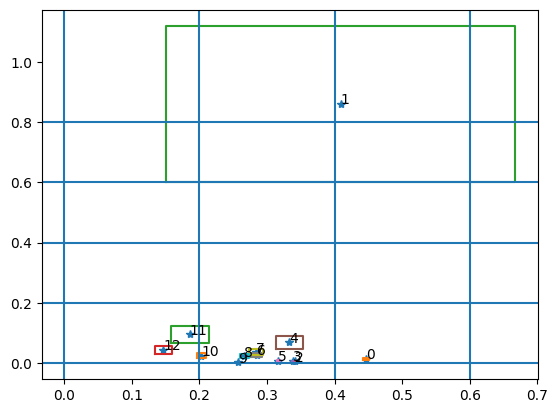

In [470]:
plt.plot(x, y, "*")
for i in range(x.size):
    plt.text(x[i], y[i], str(i))
    plt.plot( [x[i]-lam[i], x[i]+lam[i],x[i]+lam[i], x[i]-lam[i], x[i]-lam[i]],
              [y[i]-lam[i], y[i]-lam[i], y[i]+lam[i], y[i]+lam[i], y[i]-lam[i]])
for x_ in xSeq:
    plt.axvline(x_)
for y_ in ySeq:
    plt.axhline(y_)

